In [ ]:
# Package import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (mean_absolute_error,mean_squared_error,classification_report)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (LSTM, Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout)
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam

#There is a high chance of running into dependency errors as some of these package modules are getting phased out. Use the requirement.txt file to see version requirements.

In [ ]:
# !pip install keras-tuner --quiet
# This code was finished on collab so it was import to run the keras tuner everytime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


### <b>IMPORT DATA AND CALCULATE RUL</b>

In [ ]:
#load dataset from scratch as my import method was not allowing proper manipulation of the dataset
identification = ['unit_no', 'cycle_times']
operationalsettings = ['ops_1', 'ops_2', 'ops_3']
all_sensors = ['s_{}'.format(i) for i in range(1,22)]
columnnames = identification + operationalsettings + all_sensors

train_file_path = '/content/drive/MyDrive/OMSA Final Project/MGT 6748/CMAPSSData/train_FD001.txt'
test_file_path = '/content/drive/MyDrive/OMSA Final Project/MGT 6748/CMAPSSData/test_FD001.txt'
rul_file_path = '/content/drive/MyDrive/OMSA Final Project/MGT 6748/CMAPSSData/RUL_FD001.txt'

traindf = pd.read_csv(train_file_path, sep=r'\s+', header=None, names=columnnames)
testdf  = pd.read_csv(test_file_path,  sep=r'\s+', header=None, names=columnnames)
test_rul = pd.read_csv(rul_file_path,  sep=r'\s+', header=None, names=['RUL'])

In [ ]:
#calculating RUL
traindf['RUL'] = (traindf.groupby('unit_no')['cycle_times'].transform(lambda grp: grp.max() - grp))

#Applying the piecewise regression cap gotten from cited articles in the paper.
traindf['RUL'] = traindf['RUL'].clip(upper=125)

In [ ]:
#removing columns from previous EDA exploration. If you were able to use the csv file from the EDA, you wont have to run this line of code.
#### I ended up removing the sensors when calculating the rolling mean
# drop_cols = ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']

# traindf = traindf.drop(columns=drop_cols)
# testdf = testdf.drop(columns=drop_cols)

### <b>DATA PREPROCESSING</b>

In [ ]:
#PARTIAL RUL LABELLING
#identify the point of failure of each engine in teh test set. I used idxmax to retun the highest cycle times. There are other ways to go about this.
testdf['final_row'] = False
def mark_final_rows(df):
    idx = df['cycle_times'].idxmax()
    df.loc[idx, 'final_row'] = True
    return df

testdf = testdf.groupby('unit_no').apply(mark_final_rows).reset_index(drop=True)

#attach the final rul using the test_rul file to the final cycle
testdf = testdf.sort_values(['unit_no', 'cycle_times']).reset_index(drop=True)
test_engines = sorted(testdf['unit_no'].unique())

engine_to_rul = {eng: test_rul.iloc[eng-1]['RUL'] for eng in test_engines}
testdf['final_rul'] = np.nan
for i, row in testdf.iterrows():
    if row['final_row'] == True:
        eng = row['unit_no']
        testdf.at[i, 'final_rul'] = engine_to_rul[eng]

#The final_rul now contaions the final row for each engine

#calculate the partial RUL values and clip at 125 to match the train data
def compute_test_rul(df):
    final_rul_val = df.loc[df['final_row'] == True, 'final_rul'].values[0]
    max_cycle = df['cycle_times'].max()
    df['RUL'] = df['cycle_times'].apply(lambda c: final_rul_val + (max_cycle - c))
    return df

testdf = testdf.groupby('unit_no').apply(compute_test_rul).reset_index(drop=True)

#Applying the piecewise regression cap gotten from cited articles in the paper.
testdf['RUL'] = testdf['RUL'].clip(upper=125)

In [ ]:
#binary labeling as described in the paper for the classification part of the CNN. As I said in the paper, the choice to use 30 as the threshold is subjective and I couldnt find papers with just two labels
traindf['label'] = (traindf['RUL'] <= 30).astype(int)
testdf['label']  = (testdf['RUL'] <= 30).astype(int)

#### <b>ROLLING MEAN AND STD</b>

In [ ]:
#Rolling mean and standard deviation preparing the data for temporal stats. Initiall I skipped this step and my data was being read in as static instead of sequential. This is an important step.
#its also important to determin this by engine to reduce an data leakage.
#removed the sensors from the EDA that showed no good trend ['s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19'] as noted in previous cells
sensors = ['s_2','s_3','s_4','s_7','s_8','s_9','s_11','s_12','s_13','s_14','s_15','s_17','s_20','s_21']
window_size = 5 #my choice to use a window size is for simplicity, you are optimize this window size like Wang et al. (2025). Yuan et al. (2023) used a windown size of 30

# calculate rolling mean for train data
for sensor in sensors:
    traindf[f'{sensor}_mean'] = (
        traindf.groupby('unit_no')[sensor]
        .transform(lambda x: x.rolling(window_size, min_periods=1).mean())
    )
    traindf[f'{sensor}_std'] = (
        traindf.groupby('unit_no')[sensor]
        .transform(lambda x: x.rolling(window_size, min_periods=1).std().fillna(0))
    )

# calculate rolling mean for test data
for sensor in sensors:
    testdf[f'{sensor}_mean'] = (
        testdf.groupby('unit_no')[sensor]
        .transform(lambda x: x.rolling(window_size, min_periods=1).mean())
    )
    testdf[f'{sensor}_std'] = (
        testdf.groupby('unit_no')[sensor]
        .transform(lambda x: x.rolling(window_size, min_periods=1).std().fillna(0))
    )

# Fill up any NaNs because the starting window will also produce a Nan as the first row has no previous data.
traindf = traindf.fillna(method='ffill')
testdf  = testdf.fillna(method='ffill')

#### <b>SCALER</b>

In [ ]:
#combine the raw sensor, mean and std. Scaling is important as the trend map shows the distributions are not equal
sequence_features = []
for sensor in sensors:
    sequence_features.extend([sensor, f'{sensor}_mean', f'{sensor}_std'])

scaler = StandardScaler()
traindf[sequence_features] = scaler.fit_transform(traindf[sequence_features])
testdf[sequence_features]  = scaler.transform(testdf[sequence_features])

#### <b>SPLIT DATA</b>

In [ ]:
#split based on engines. This was another method to control data leakage. My initial model didn not improve after hyperparameter tuning and it was as a result of data leakage
train_engines, val_engines = train_test_split(traindf['unit_no'].unique(),test_size=0.2,random_state=42)
df_train  = traindf[traindf['unit_no'].isin(train_engines)]
df_val    = traindf[traindf['unit_no'].isin(val_engines)]

#### <b>SLIDING WINDOWS </b>

In [ ]:
#time series data is sequential and for the sake of a CNN model, it has to be fed a sequential data. The data will be converted to flat for the base model and it explains why the base models did not improve after tuning.
#sliding windows based on sequence lenght of 20 (20 connsecutive time steps)
sequence_length = 20

#this function will sort data by cucle times and use a 20 slide window to sort along the data
def create_sequences(df, seq_length, feature_cols, label_col='RUL'):
    X_seq, Y_label = [], []
    for eng_id, eng_data in df.groupby('unit_no'): #very essential to avoid data leakage
        eng_data = eng_data.sort_values('cycle_times').reset_index(drop=True)
        for start_idx in range(len(eng_data) - seq_length + 1):
            seq_slice = eng_data.iloc[start_idx : start_idx + seq_length]
            X_seq.append(seq_slice[feature_cols].values)

            Y_label.append(seq_slice.iloc[-1][label_col])
    return np.array(X_seq), np.array(Y_label)

# Build sequences for train/val
X_train_seq_reg, y_train_reg = create_sequences(df_train, sequence_length, sequence_features, 'RUL')
X_val_seq_reg,   y_val_reg   = create_sequences(df_val,   sequence_length, sequence_features, 'RUL')

# Also build classification labels
_, y_train_class = create_sequences(df_train, sequence_length, sequence_features, 'label')
_, y_val_class   = create_sequences(df_val,   sequence_length, sequence_features, 'label')

### <b>REGRESSION BASE MODELS </b>

In [ ]:
#base models for comparison. my initial hypothesis was that base models will outperform if properly tuned, but I realized that tuning and SVR was costing me time.
#all base models are commented out to save time for running the main CNN model

# Flating needed and this is why conventional models dont do so well.
X_train_flat_reg = X_train_seq_reg.reshape(len(X_train_seq_reg), -1)
X_val_flat_reg   = X_val_seq_reg.reshape(len(X_val_seq_reg), -1)

#REGRESSION MODELS
# Linear Regression
lin_reg = LinearRegression().fit(X_train_flat_reg, y_train_reg)
pred_lin = lin_reg.predict(X_val_flat_reg)
print('Linear Reg MAE:', mean_absolute_error(y_val_reg, pred_lin))

# SVR
svr_reg = SVR().fit(X_train_flat_reg, y_train_reg)
pred_svr = svr_reg.predict(X_val_flat_reg)
print('SVR MAE:', mean_absolute_error(y_val_reg, pred_svr))

# Decision Tree Regressor
dt_reg = DecisionTreeRegressor(random_state=42).fit(X_train_flat_reg, y_train_reg)
pred_dt = dt_reg.predict(X_val_flat_reg)
print('Decision Tree MAE:', mean_absolute_error(y_val_reg, pred_dt))

# Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42).fit(X_train_flat_reg, y_train_reg)
pred_rf = rf_reg.predict(X_val_flat_reg)
print('Random Forest MAE:', mean_absolute_error(y_val_reg, pred_rf))

### <b>CLASSIFICATION BASE MODELS </b>

In [ ]:
#CLASSFICATION MODELS
# Flatten for classification
X_train_flat_class = X_train_flat_reg
X_val_flat_class   = X_val_flat_reg


# Logistic Regression
log_clf = LogisticRegression(max_iter=500, random_state=42)
log_clf.fit(X_train_flat_class, y_train_class)
pred_log = log_clf.predict(X_val_flat_class)
print("Logistic Regression", classification_report(y_val_class, pred_log))

# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train_flat_class, y_train_class)
pred_dt_clf = dt_clf.predict(X_val_flat_class)
print("Decision Tree Classifier", classification_report(y_val_class, pred_dt_clf))

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_flat_class, y_train_class)
pred_rf_clf = rf_clf.predict(X_val_flat_class)
print("Random Forest Classifier", classification_report(y_val_class, pred_rf_clf))

### <b>Multi-task CNN (no lSTM layer)</b>

<ipython-input-4-444bdaddfeeb>:29: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch
<ipython-input-4-444bdaddfeeb>:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  testdf = testdf.groupby('unit_no').apply(mark_final_rows).reset_index(drop=True)
<ipython-input-4-444bdaddfeeb>:100: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Epoch 1/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - class_output_accuracy: 0.6414 - class_output_loss: 1.3518 - class_output_precision: 0.2402 - class_output_recall: 0.5078 - loss: 1063.8557 - reg_output_loss: 2125.0015 - reg_output_mae: 34.5025 - reg_output_mse: 2125.0073 - val_class_output_accuracy: 0.8789 - val_class_output_loss: 0.2549 - val_class_output_precision: 0.8192 - val_class_output_recall: 0.3581 - val_loss: 236.8965 - val_reg_output_loss: 478.9654 - val_reg_output_mae: 17.6653 - val_reg_output_mse: 473.2966
Epoch 2/20
471/471 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - class_output_accuracy: 0.7857 - class_output_loss: 0.6861 - class_output_precision: 0.4047 - class_output_recall: 0.6053 - loss: 280.5721 - reg_output_loss: 559.7718 - reg_output_mae: 18.9432 - reg_output_mse: 559.7722 - val_class_output_accuracy: 0.8827 - val_class_output_loss: 0.2898 - val_class_output_precision: 0.6101 - val_class_output_recall: 0.8355 - val_loss: 218.6113 - val_reg_output_loss: 440.1425 - val

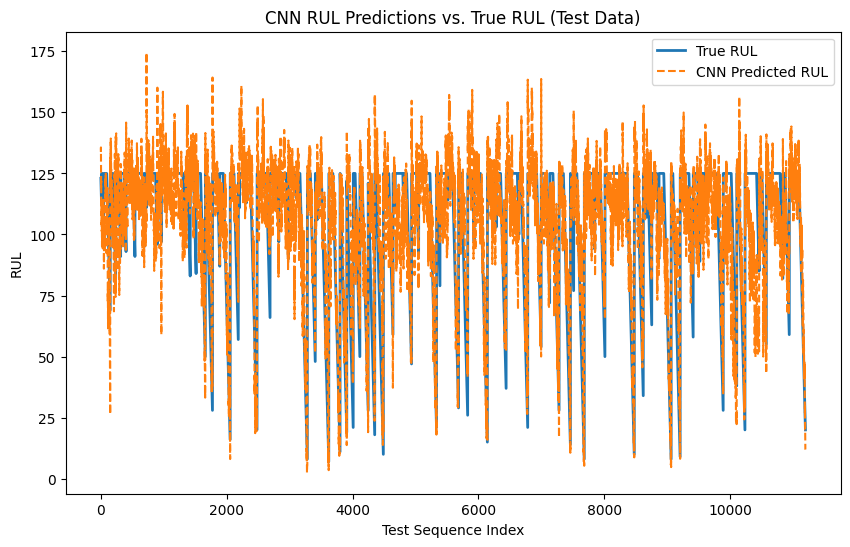

In [ ]:
#Multi-task CNN (classification and regression model)
num_features = len(sequence_features)

input_layer = Input(shape=(sequence_length, num_features))
x = Conv1D(32, kernel_size=3, activation='relu')(input_layer)
x = MaxPooling1D(2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)


class_output = Dense(1, activation='sigmoid', name='class_output')(x)
reg_output   = Dense(1, activation='linear',  name='reg_output')(x)

model = Model(inputs=input_layer, outputs=[class_output, reg_output])

model.compile(optimizer='adam',loss=['binary_crossentropy','mse'],
    metrics={
        'class_output': ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
        'reg_output':   ['mae','mse']
    }
)

class_weights_array = compute_class_weight('balanced',classes=np.array([0,1]),y=y_train_class)
sample_weights_class = np.array([class_weights_array[int(lbl)] for lbl in y_train_class])

##VALIDATION SET
# Fit the CNN model here
model.fit(
    X_train_seq_reg,
    [y_train_class, y_train_reg],
    validation_data=(X_val_seq_reg, [y_val_class, y_val_reg]),
    epochs=20,
    batch_size=32,
    sample_weight=[sample_weights_class, np.ones_like(y_train_reg)]
)

# evaluating model perfomance on validation dataset
preds_class_val, preds_reg_val = model.predict(X_val_seq_reg)

#Print all reporting metrics for validation dataset
print("CNN Classification Report (Val", classification_report(y_val_class, preds_class_val.round()))
mae_val = mean_absolute_error(y_val_reg, preds_reg_val)
rmse_val= np.sqrt(mean_squared_error(y_val_reg, preds_reg_val))
print("CNN Val Regression MAE:", mae_val)
print("CNN Val Regression RMSE:", rmse_val)

###FULL SET
# retrian on full dataset that is TRAIN+VAL & evaluate on test set that has true RUL values
# Combine train+val for final training
X_full_seq = np.concatenate([X_train_seq_reg, X_val_seq_reg])
y_full_class = np.concatenate([y_train_class, y_val_class])
y_full_reg   = np.concatenate([y_train_reg,   y_val_reg])

# adding weights for full set
class_weights_full = compute_class_weight('balanced', classes=np.array([0,1]), y=y_full_class)
sample_weights_full_class = np.array([class_weights_full[int(lbl)] for lbl in y_full_class])

# retrianing the model
model.fit(X_full_seq,[y_full_class, y_full_reg],epochs=20,batch_size=32,sample_weight=[sample_weights_full_class, np.ones_like(y_full_reg)])

# evaluating model perfomance on full training dataset (train + val)
preds_class_full, preds_reg_full = model.predict(X_full_seq)

# Print all reporting metrics for full dataset
print("CNN Classification Report (Full Training):\n", classification_report(y_full_class, preds_class_full.round()))
mae_full = mean_absolute_error(y_full_reg, preds_reg_full)
rmse_full = np.sqrt(mean_squared_error(y_full_reg, preds_reg_full))
print("CNN Full Training Regression MAE:", mae_full)
print("CNN Full Training Regression RMSE:", rmse_full)


# FINAL TEST DATA EVALUATION
X_test_seq_reg, y_test_reg = create_sequences(testdf, sequence_length, sequence_features, 'RUL')
_, y_test_class = create_sequences(testdf, sequence_length, sequence_features, 'label')

# print(f"X_test_seq_reg shape: {X_test_seq_reg.shape}")

# Predict on the final test partial runs
preds_class_test, preds_reg_test = model.predict(X_test_seq_reg)

# evaluating model perfomance on final test dataset
print("Final Test Set Classification Report:",classification_report(y_test_class, preds_class_test.round()))
mae_test  = mean_absolute_error(y_test_reg, preds_reg_test)
rmse_test = np.sqrt(mean_squared_error(y_test_reg, preds_reg_test))
print("Final Test Set Regression MAE:", mae_test)
print("Final Test Set Regression RMSE:", rmse_test)


# VISUALS
plt.figure(figsize=(10,6))
plt.plot(y_test_reg, label='True RUL', linewidth=2)
plt.plot(preds_reg_test, label='CNN Predicted RUL', linestyle='--')
plt.xlabel('Test Sequence Index')
plt.ylabel('RUL')
plt.title('CNN RUL Predictions vs. True RUL (Test Data)')
plt.legend()
plt.show()



### <b>Multi-task CNN (lSTM layer)</b>

In [ ]:

# Define model for tuning
def build_multitask_model(hp):
    input_layer = Input(shape=(sequence_length, len(sequence_features)))

    x = Conv1D(
        filters=hp.Choice('conv_filters', [32, 64, 128]),
        kernel_size=3,
        activation='relu',
        padding='same'
    )(input_layer)

    x = MaxPooling1D(pool_size=2)(x)

    x = LSTM(
        units=hp.Choice('lstm_units', [32, 64, 128]),
        return_sequences=False
    )(x)

    x = Dense(
        units=hp.Choice('dense_units', [64, 128, 256]),
        activation='relu'
    )(x)

    x = Dropout(rate=hp.Float('dropout_rate', 0.2, 0.5, step=0.1))(x)


    class_output = Dense(1, activation='sigmoid', name='class_output')(x)
    reg_output = Dense(1, activation='linear', name='reg_output')(x)

    model = Model(inputs=input_layer, outputs=[class_output, reg_output])

    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss={'class_output': 'binary_crossentropy', 'reg_output': 'mse'},
        loss_weights={'class_output': 1.0, 'reg_output': 0.5},
        metrics={
            'class_output': ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
            'reg_output': ['mae', 'mse']
        }
    )
    return model

# tuner
tuner = RandomSearch(build_multitask_model,objective='val_loss',max_trials=10,executions_per_trial=1,directory='cnn_lstm_tuning',project_name='rul_multitask_tuning')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)

# apply tuner search
tuner.search(X_train_seq_reg,[y_train_class, y_train_reg],validation_data=(X_val_seq_reg, [y_val_class, y_val_reg]),epochs=40,batch_size=32,sample_weight=[sample_weights_class, np.ones_like(y_train_reg)],
    callbacks=[early_stop, lr_schedule]
)

# Get best model
best_hp = tuner.get_best_hyperparameters(1)[0]
final_model = build_multitask_model(best_hp)


#retrain model with best hyperparameters
final_model.fit(X_full_seq,[y_full_class, y_full_reg],epochs=50,batch_size=32,sample_weight=[sample_weights_full_class, np.ones_like(y_full_reg)],verbose=1)
preds_class_test, preds_reg_test = final_model.predict(X_test_seq_reg)


print("Final Test Set Classification Report:")
print(classification_report(y_test_class, preds_class_test.round()))


mae_test  = mean_absolute_error(y_test_reg, preds_reg_test)
rmse_test = np.sqrt(mean_squared_error(y_test_reg, preds_reg_test))
print("Final Test Set Regression MAE:", mae_test)
print("Final Test Set Regression RMSE:", rmse_test)

# Visuals
# plt.figure(figsize=(10, 6))
# plt.plot(y_test_reg, label='True RUL', linewidth=2)
# plt.plot(preds_reg_test, label='Predicted RUL (CNN-LSTM)', linestyle='--')
# plt.xlabel('Test Sequence Index')
# plt.ylabel('Remaining Useful Life (RUL)')
# plt.title('CNN-LSTM Final RUL Predictions on Test Set')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


Trial 10 Complete [00h 06m 26s]
val_loss: 126.04454040527344

Best val_loss So Far: 118.86190032958984
Total elapsed time: 00h 35m 05s
Epoch 1/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - class_output_accuracy: 0.6652 - class_output_loss: 0.9487 - class_output_precision_1: 0.2044 - class_output_recall_1: 0.3587 - loss: 2874.9470 - reg_output_loss: 5747.9844 - reg_output_mae: 64.0801 - reg_output_mse: 5747.9951
Epoch 2/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - class_output_accuracy: 0.8434 - class_output_loss: 0.5824 - class_output_precision_1: 0.5201 - class_output_recall_1: 0.7417 - loss: 275.8849 - reg_output_loss: 550.6042 - reg_output_mae: 18.8628 - reg_output_mse: 550.6051
Epoch 3/50
586/586 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - class_output_accuracy: 0.8973 - class_output_loss: 0.3074 - class_output_precision_1: 0.6421 - class_output_recall_1: 0.8674 - loss: 170.1100 - reg_output_loss: 339.6055 - reg_output_mae: 13.9750 - reg_output_mse: 339.6053
Epoch 4/50
586/586 ━━━━━━

NameError: name 'X_test_seq' is not defined

350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step

Final Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10864
           1       0.79      0.78      0.78       332

    accuracy                           0.99     11196
   macro avg       0.89      0.89      0.89     11196
weighted avg       0.99      0.99      0.99     11196

Final Test Set Regression MAE: 11.648571994739926
Final Test Set Regression RMSE: 17.31692492917181


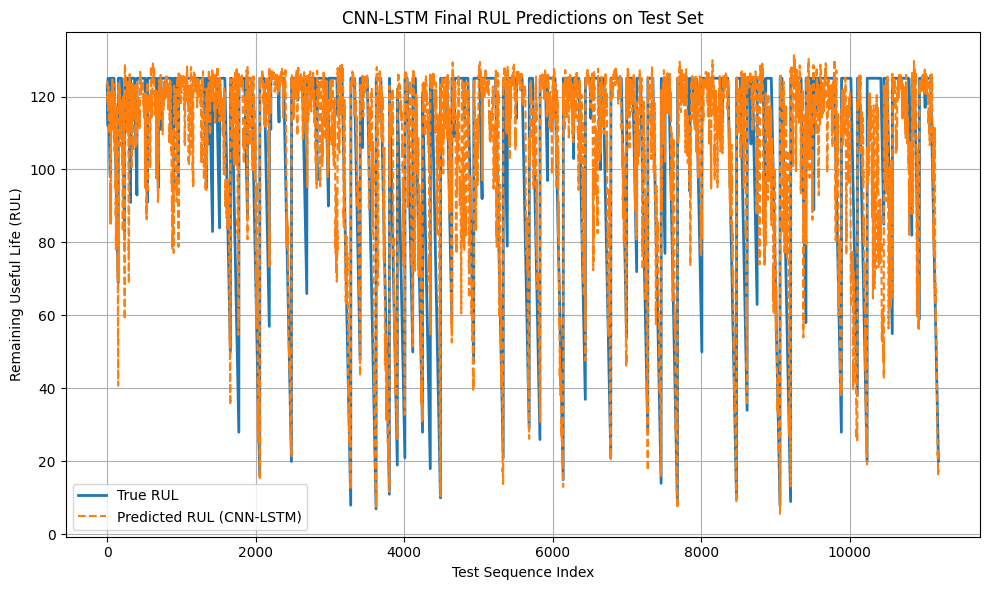

In [ ]:
# final test evaluation of the CNN-LSTM model
preds_class_test, preds_reg_test = final_model.predict(X_test_seq_reg)


print("Final Test Set Classification Report:")
print(classification_report(y_test_class, preds_class_test.round()))


mae_test  = mean_absolute_error(y_test_reg, preds_reg_test)
rmse_test = np.sqrt(mean_squared_error(y_test_reg, preds_reg_test))
print("Final Test Set Regression MAE:", mae_test)
print("Final Test Set Regression RMSE:", rmse_test)

plt.figure(figsize=(10, 6))
plt.plot(y_test_reg, label='True RUL', linewidth=2)
plt.plot(preds_reg_test, label='Predicted RUL (CNN-LSTM)', linestyle='--')
plt.xlabel('Test Sequence Index')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title('CNN-LSTM Final RUL Predictions on Test Set')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1]:
# Evaluate model on full training data (train + val)
# preds_class_full, preds_reg_full = model.predict(X_full_seq)

# # Classification metrics (train + val)
# print("CNN Classification Report (Full Training):\n", classification_report(y_full_class, preds_class_full.round()))
# mae_full = mean_absolute_error(y_full_reg, preds_reg_full)
# rmse_full = np.sqrt(mean_squared_error(y_full_reg, preds_reg_full))
# print("CNN Full Training Regression MAE:", mae_full)
# print("CNN Full Training Regression RMSE:", rmse_full)